# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [50]:
import numpy as np
import os

from PIL import Image
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [51]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [52]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
#the batch size
batch_size = 10

#### Check the train and validation csv data

In [53]:
import pandas as pd

train_df = pd.read_csv('/home/datasets/Project_data/train.csv', sep=';', header=None)
train_df.head()

,0,1,2
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0


In [54]:
val_df = pd.read_csv('/home/datasets/Project_data/val.csv', sep=';', header=None)
val_df.head()

,0,1,2
0,WIN_20180925_17_17_04_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_43_01_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_18_01_40_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_18_03_21_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180926_16_46_22_Pro_Left_Swipe_new,Left_Swipe_new,0


#### Check all data counts for each gesture class

In [55]:
print("Training Data Class Counts: ")
print(train_df[2].value_counts())

Training Data Class Counts: 
3    137
1    137
0    136
2    130
4    123
Name: 2, dtype: int64


In [56]:
print("Validation Data Class Counts: ")
print(val_df[2].value_counts())

Validation Data Class Counts: 
1    23
2    22
3    21
0    18
4    16
Name: 2, dtype: int64


> Checking from the data above. There is No Class Imbalance and there are enough no of images for each gesture recognition. Hence Augmentation of Data is not needed

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [57]:
### Function to process images i.e. read, crop, resize and return the batch_data

def processImageBatch(t, source_path, img_idx, x, y, z, batchNum, batch_size):
    batch_data = np.zeros((batch_size,x,y,z,3)) 
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batchNum*batch_size)].split(';')[0])) # read all the images in the folder
        for idx,item in enumerate(img_idx): 
            #  Iterate iver the frames/images of a folder to read them in
            image = Image.open(source_path+'/'+ t[folder + (batchNum*batch_size)].strip().split(';')[0]+'/'+imgs[item])
            #crop the images and resize them. Note that the images are of 2 different shape
            width, height = image.size
            lft, rgt, top, btm = 5, width-10, 5, height
            image = image.crop((lft, top, rgt, btm))
            image = image.resize((y,z))
            image = np.asarray(image,dtype=np.float32)
            
            #normalise and feed in the image
            batch_data[folder,idx,:,:,0] = image[:,:,0].T/255
            batch_data[folder,idx,:,:,1] = image[:,:,1].T/255
            batch_data[folder,idx,:,:,2] = image[:,:,2].T/255
                    
        batch_labels[folder, int(t[folder + (batchNum*batch_size)].strip().split(';')[2])] = 1
    return batch_data,batch_labels

In [71]:
### genrator function to yield the processed images
#img_idx=[5,11,17,23,29]
img_idx=[2,5,8,11,14,17,20,23,26,29]
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)
        x, y, z = len(img_idx), 120, 160
        num_batches = len(folder_list)//batch_size  # calculate the number of batches
        remaining_batches = len(folder_list) % batch_size
        for batchNum in range(num_batches) :
            yield processImageBatch(t, source_path, img_idx, x, y, z, batchNum, batch_size)
        if remaining_batches > 0 :
            yield processImageBatch(t,source_path, img_idx, x, y, z, num_batches, remaining_batches)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [72]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


#### Check generator function

In [73]:
train_data = generator(train_path, train_doc, batch_size)
image_batch, label = next(train_data)
print('input shape: ',image_batch[0].shape,' label: ', label[0])

Source path =  /home/datasets/Project_data/train ; batch size = 10
input shape:  (10, 120, 160, 3)  label:  [0. 0. 1. 0. 0.]


#### Check Images within the Batch

In [74]:
def getBatchImages(batch_size, image_batch, img_index_len):
    plt.figure(figsize=(19,30))
    idx = 1
    for n in range(batch_size):
        for i in range(img_index_len):
            ax = plt.subplot(batch_size, img_index_len, idx)
            plt.imshow(np.rot90(image_batch[n,i],3))
            plt.axis('off')
            idx+=1

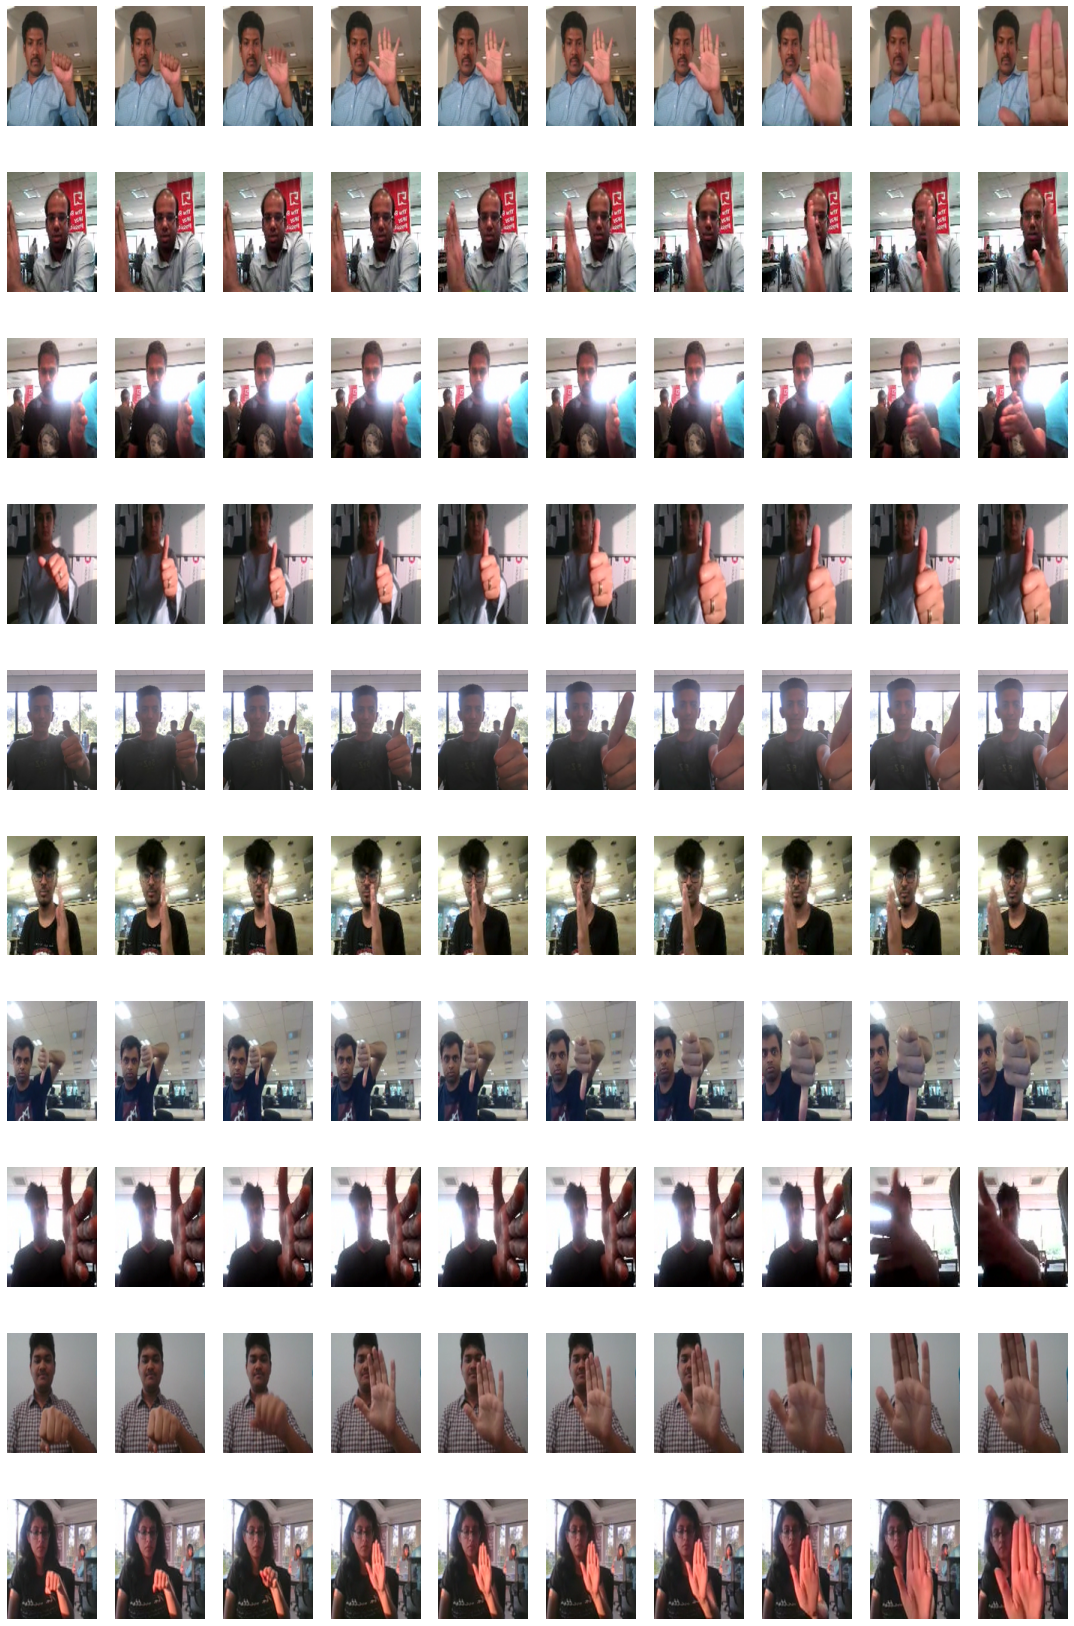

In [75]:
getBatchImages(batch_size, image_batch, len(img_idx))

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### 1 : Conv 3D without BN

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()

#first conv layer
model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape = image_batch[0].shape))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

#fully connected layer 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(len(label[0]), activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [66]:
#optimizer
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 3, 118, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 1, 59, 79, 32)     0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 59, 79, 32)     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 149152)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                9545792   
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [67]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [68]:
model_name = 'model_1_conv3D_wo_bn_5_img' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, vpatience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [69]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [70]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 2.5378 - categorical_accuracy: 0.3152Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.23987, saving model to model_1_conv3D_wo_bn_5_img_2021-08-3121_19_18.560942/model-00001-2.53779-0.31523-1.23987-0.45000.h5
67/67 [==============================] - 18s 275ms/step - loss: 2.5378 - categorical_accuracy: 0.3152 - val_loss: 1.2399 - val_categorical_accuracy: 0.4500
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.9994 - categorical_accuracy: 0.6033
Epoch 00002: val_loss improved from 1.23987 to 0.82422, saving model to model_1_conv3D_wo_bn_5_img_2021-08-3121_19_18.560942/model-00002-0.99935-0.60332-0.82422-0.63000.h5
67/67 [==============================] - 17s 251ms/step - loss: 0.9994 - categorical_accuracy: 0.6033 - val_loss: 0.8242 - val_categorical_accuracy: 0.6300
Epoc

### 1.1 : Conv 3D without BN with 10 Image Indexs

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model1 = Sequential()

#first conv layer
model1.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape = image_batch[0].shape))
model1.add(MaxPooling3D(pool_size=(2,2,2)))
model1.add(Dropout(0.25))

#second conv layer
model1.add(Conv3D(32, kernel_size=(3,3,3), activation='relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model1.add(Dropout(0.25))

#fully connected layer 
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.25))

#softmax layer
model1.add(Dense(len(label[0]), activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [77]:
#optimizer
optimiser = 'adam'
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 8, 118, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 4, 59, 79, 32)     0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 59, 79, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 2, 57, 77, 32)     27680     
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 1, 29, 39, 32)     0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 29, 39, 32)     0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 36192)            

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [78]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [79]:
model_name = 'model_1_1_conv3D_wo_bn_10_img' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, vpatience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [80]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [81]:
model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6709 - categorical_accuracy: 0.2443Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.44023, saving model to model_1_1_conv3D_wo_bn_10_img_2021-08-3121_29_35.446037/model-00001-1.67094-0.24434-1.44023-0.40000.h5
67/67 [==============================] - 30s 442ms/step - loss: 1.6709 - categorical_accuracy: 0.2443 - val_loss: 1.4402 - val_categorical_accuracy: 0.4000
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2996 - categorical_accuracy: 0.4465
Epoch 00002: val_loss improved from 1.44023 to 1.11132, saving model to model_1_1_conv3D_wo_bn_10_img_2021-08-3121_29_35.446037/model-00002-1.29961-0.44646-1.11132-0.52000.h5
67/67 [==============================] - 29s 436ms/step - loss: 1.2996 - categorical_accuracy: 0.4465 - val_loss: 1.1113 - val_categorical_accuracy: 0.520

### 2 : Conv 3D with BN

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model2 = Sequential()

#first conv layer
model2.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape = image_batch[0].shape))
model2.add(MaxPooling3D(pool_size=(2,2,2)))
model2.add(BatchNormalization()) 

#second conv layer
model2.add(Conv3D(32, kernel_size=(3,3,3), activation='relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model2.add(BatchNormalization())

#fully connected layer 
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.50))

#softmax layer
model2.add(Dense(len(label[0]), activation='softmax'))

In [89]:
#optimizer
optimiser = 'sgd'
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 8, 118, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 4, 59, 79, 32)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 59, 79, 32)     128       
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 2, 57, 77, 32)     27680     
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 1, 29, 39, 32)     0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 1, 29, 39, 32)     128       
_________________________________________________________________
flatten_8 (Flatten)          (None, 36192)           

In [84]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [85]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_2_conv3D_with_bn' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, vpatience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

In [86]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [87]:
model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
66/67 [============================>.] - ETA: 0s - loss: 2.6446 - categorical_accuracy: 0.3939Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.95883, saving model to model_2_conv3D_with_bn_2021-08-3121_43_27.044355/model-00001-2.63758-0.39517-1.95883-0.26000.h5
67/67 [==============================] - 29s 434ms/step - loss: 2.6376 - categorical_accuracy: 0.3952 - val_loss: 1.9588 - val_categorical_accuracy: 0.2600
Epoch 2/20
66/67 [============================>.] - ETA: 0s - loss: 1.0932 - categorical_accuracy: 0.6273
Epoch 00002: val_loss did not improve from 1.95883
67/67 [==============================] - 29s 428ms/step - loss: 1.0907 - categorical_accuracy: 0.6275 - val_loss: 2.3029 - val_categorical_accuracy: 0.3100
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.6452 - categorical_accuracy: 0.7617
Epoch 00003: val_loss d

### 3 : Conv 2D with GRU

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model3 = Sequential()

#first conv+RNN layer
model3.add(TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape= image_batch[0].shape)))
model3.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model3.add(BatchNormalization())

#second conv+RNN layer
model3.add(TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')))
model3.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model3.add(BatchNormalization())

model3.add(TimeDistributed(Flatten()))
model3.add(GRU(128,activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(len(label[0]), activation='softmax'))

In [91]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [92]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [93]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_3_conv2D_with_GRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, vpatience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

In [96]:
model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 8.3919 - categorical_accuracy: 0.3741Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 3.40033, saving model to model_3_conv2D_with_GRU_2021-08-3121_58_33.142757/model-00001-8.39187-0.37406-3.40033-0.22000.h5
67/67 [==============================] - 34s 506ms/step - loss: 8.3919 - categorical_accuracy: 0.3741 - val_loss: 3.4003 - val_categorical_accuracy: 0.2200
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 3.6392 - categorical_accuracy: 0.4253
Epoch 00002: val_loss improved from 3.40033 to 2.37900, saving model to model_3_conv2D_with_GRU_2021-08-3121_58_33.142757/model-00002-3.63924-0.42534-2.37900-0.21000.h5
67/67 [==============================] - 32s 471ms/step - loss: 3.6392 - categorical_accuracy: 0.4253 - val_loss: 2.3790 - val_categorical_accuracy: 0.2100
Epoch 3/20

In [97]:
#optimizer
optimiser = 'adam'
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, None, None, None,  1792      
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, None, None,  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, None, None, None,  256       
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, None, None,  36928     
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, None, None,  0         
_________________________________________________________________
batch_normalization_14 (Batc (None, None, None, None,  256       
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, None)      

### 4 : Conv 3D with Conv LSTM 2D

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, ConvLSTM2D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model4 = Sequential()

#first conv layer
model4.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape = image_batch[0].shape))
model4.add(MaxPooling3D(pool_size=(2,2,2)))
model4.add(BatchNormalization()) 
model4.add(Dropout(0.25))


model4.add(ConvLSTM2D(16, kernel_size=(3,3), padding='same', return_sequences = True))
model4.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model4.add(BatchNormalization())

#fully connected layer 
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.50))

#softmax layer
model4.add(Dense(len(label[0]), activation='softmax'))

In [99]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [100]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [101]:
model_name = 'model_4_conv3D_with_LSTM_2D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, vpatience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

In [103]:
#optimizer
optimiser = 'sgd'
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 8, 118, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 4, 59, 79, 32)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 4, 59, 79, 32)     128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 4, 59, 79, 32)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 4, 59, 79, 16)     27712     
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 2, 30, 40, 16)     0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 2, 30, 40, 16)   

In [ ]:
model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 3.0862 - categorical_accuracy: 0.3213Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.84595, saving model to model_4_conv3D_with_LSTM_2D_2021-08-3121_58_33.142757/model-00001-3.08624-0.32127-1.84595-0.25000.h5
67/67 [==============================] - 32s 482ms/step - loss: 3.0862 - categorical_accuracy: 0.3213 - val_loss: 1.8460 - val_categorical_accuracy: 0.2500
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.3900 - categorical_accuracy: 0.4766
Epoch 00002: val_loss improved from 1.84595 to 1.37729, saving model to model_4_conv3D_with_LSTM_2D_2021-08-3121_58_33.142757/model-00002-1.38997-0.47662-1.37729-0.45000.h5
67/67 [==============================] - 31s 470ms/step - loss: 1.3900 - categorical_accuracy: 0.4766 - val_loss: 1.3773 - val_categorical_accuracy: 0.4500
Ep